CSC with a Spatial Mask
=======================

This example demonstrates the use of [cbpdn.AddMaskSim](http://sporco.rtfd.org/en/latest/modules/sporco.admm.cbpdn.html#sporco.admm.cbpdn.AddMaskSim) for convolutional sparse coding with a spatial mask [[50]](http://sporco.rtfd.org/en/latest/zreferences.html#wohlberg-2016-boundary). If the ``sporco-cuda`` extension is installed and a GPU is available, a GPU accelerated version is used. The example problem is inpainting of randomly distributed corruption of a greyscale image. This is the same problem solved by example ``cbpdn_ams_gry``, but with a different approach to handling of the lowpass image components. In this example, instead of pre-processing with a non-linear lowpass filter, the lowpass components are represented within the main optimisation problem via an impulse filter with gradient regularization on the corresponding coefficient map (see Sec. 3 and Sec. 4 of [[52]](http://sporco.rtfd.org/en/latest/zreferences.html#wohlberg-2016-convolutional2)).

In [1]:
from __future__ import print_function
from builtins import input

import pyfftw   # See https://github.com/pyFFTW/pyFFTW/issues/40
import numpy as np

from sporco import util
from sporco import signal
from sporco import metric
from sporco import plot
plot.config_notebook_plotting()
from sporco.admm import cbpdn
from sporco.fft import fftconv
from sporco import cuda

# If running in a notebook, try to use wurlitzer so that output from the CUDA
# code will be properly captured in the notebook.
sys_pipes = util.notebook_system_output()

Load a reference image.

In [2]:
img = util.ExampleImages().image('monarch.png', zoom=0.5, scaled=True,
                                 gray=True, idxexp=np.s_[:, 160:672])

Create random mask and apply to reference image to obtain test image. (The call to ``numpy.random.seed`` ensures that the pseudo-random noise is reproducible.)

In [3]:
np.random.seed(12345)
frc = 0.5
msk = signal.rndmask(img.shape, frc, dtype=np.float32)
imgw = msk * img

Define pad and crop functions.

In [4]:
pn = 8
spad = lambda x: np.pad(x, pn, mode='symmetric')
zpad = lambda x: np.pad(x, pn, mode='constant')
crop = lambda x: x[pn:-pn, pn:-pn]

Construct padded mask and test image.

In [5]:
mskp = zpad(msk)
imgwp = spad(imgw)

Load dictionary.

In [6]:
D = util.convdicts()['G:8x8x128']
di = np.zeros(D.shape[0:2] + (1,), dtype=np.float32)
di[0, 0] = 1
Di = np.dstack((di, D))

Set up weights for the $\ell_1$ norm to disable regularization of the coefficient map corresponding to the impulse filter intended to represent lowpass image components (not to be confused with the AMS impulse filter used to implement spatial masking).

In [7]:
wl1 = np.ones((1,)*2 + (Di.shape[2:]), dtype=np.float32)
wl1[..., 0] = 0.0
wl1i = np.concatenate((wl1, np.zeros(wl1.shape[0:-1] + (1,))), axis=-1)

When representing lowpass image components using an impulse filter together with an $\ell_2$ norm on the gradient of its coefficient map, we usually want to set the weight array for this norm (specified by the ``GradWeight`` option) to disable regularization of all coefficient maps except for the one corresponding to that impulse filter (not to be confused with the AMS impulse filter used to implement spatial masking). In this case set a non-zero value for the weights of the other coefficient maps size this improves performance in this inpainting problem.

In [8]:
#wgr = np.zeros((Di.shape[2]), dtype=np.float32)
wgr = 2e-1 * np.ones((Di.shape[2]), dtype=np.float32)
wgr[0] = 1.0
wgri = np.hstack((wgr, np.zeros((1,))))

Set up [admm.cbpdn.ConvBPDNGradReg](http://sporco.rtfd.org/en/latest/modules/sporco.admm.cbpdn.html#sporco.admm.cbpdn.ConvBPDNGradReg) options.

In [9]:
lmbda = 1e-2
mu = 2e-1
opt = cbpdn.ConvBPDNGradReg.Options({'Verbose': True, 'MaxMainIter': 200,
                    'HighMemSolve': True, 'RelStopTol': 5e-3,
                    'AuxVarObj': False, 'RelaxParam': 1.8,
                    'rho': 5e1*lmbda + 1e-1, 'L1Weight': wl1,
                    'GradWeight': wgr, 'AutoRho': {'Enabled': False,
                    'StdResiduals': False}})

Construct [admm.cbpdn.AddMaskSim](http://sporco.rtfd.org/en/latest/modules/sporco.admm.cbpdn.html#sporco.admm.cbpdn.AddMaskSim) wrapper for [admm.cbpdn.ConvBPDNGradReg](http://sporco.rtfd.org/en/latest/modules/sporco.admm.cbpdn.html#sporco.admm.cbpdn.ConvBPDNGradReg) and solve via wrapper. If the ``sporco-cuda`` extension is installed and a GPU is available, use the CUDA implementation of this combination.

In [10]:
if cuda.device_count() > 0:
    opt['L1Weight'] = wl1
    opt['GradWeight'] = wgr
    ams = None
    print('%s GPU found: running CUDA solver' % cuda.device_name())
    tm = util.Timer()
    with sys_pipes(), util.ContextTimer(tm):
        X = cuda.cbpdngrdmsk(Di, imgwp, mskp, lmbda, mu, opt)
    t = tm.elapsed()
    imgr = crop(np.sum(fftconv(Di, X, axes=(0, 1)), axis=-1))
else:
    opt['L1Weight'] = wl1i
    opt['GradWeight'] = wgri
    ams = cbpdn.AddMaskSim(cbpdn.ConvBPDNGradReg, Di, imgwp, mskp, lmbda, mu,
                           opt=opt)
    X = ams.solve().squeeze()
    t = ams.timer.elapsed('solve')
    imgr = crop(ams.reconstruct().squeeze())

GeForce RTX 2080 Ti GPU found: running CUDA solver


Itn   Fnc       DFid      Regℓ1     Regℓ2∇     r         s         ρ
--------------------------------------------------------------------------
   0  3.55e+02  1.60e+02  1.87e+04  3.89e+01  5.80e-01  1.48e+00  6.00e-01
   1  2.80e+02  2.58e+01  2.34e+04  9.95e+01  3.81e-01  6.79e-01  6.00e-01
   2  2.62e+02  2.97e+01  2.07e+04  1.27e+02  2.64e-01  9.15e-01  6.00e-01
   3  1.74e+02  1.15e+01  1.44e+04  9.41e+01  1.35e-01  4.51e-01  6.00e-01
   4  1.61e+02  4.48e+00  1.39e+04  8.77e+01  1.06e-01  2.41e-01  6.00e-01
   5  1.41e+02  3.15e+00  1.20e+04  8.79e+01  7.19e-02  2.65e-01  6.00e-01
   6  1.29e+02  3.39e+00  1.08e+04  8.37e+01  5.07e-02  1.96e-01  6.00e-01
   7  1.13e+02  2.49e+00  9.54e+03  7.77e+01  4.22e-02  1.63e-01  6.00e-01
   8  1.05e+02  1.99e+00  8.84e+03  7.39e+01  3.54e-02  1.56e-01  6.00e-01
   9  9.92e+01  2.14e+00  8.29e+03  7.05e+01  3.05e-02  1.41e-01  6.00e-01
  10  9.19e+01  2.05e+00  7.63e+03  6.77e+01  2.72e-02  1.37e-01  6.00e-01
  11  8.95e+01  1.84e+00  7.46e

Display solve time and reconstruction performance.

In [11]:
print("AddMaskSim wrapped ConvBPDN solve time: %.2fs" % t)
print("Corrupted image PSNR: %5.2f dB" % metric.psnr(img, imgw))
print("Recovered image PSNR: %5.2f dB" % metric.psnr(img, imgr))

AddMaskSim wrapped ConvBPDN solve time: 1.57s
Corrupted image PSNR:  9.10 dB
Recovered image PSNR: 25.51 dB


Display reference, test, and reconstructed image

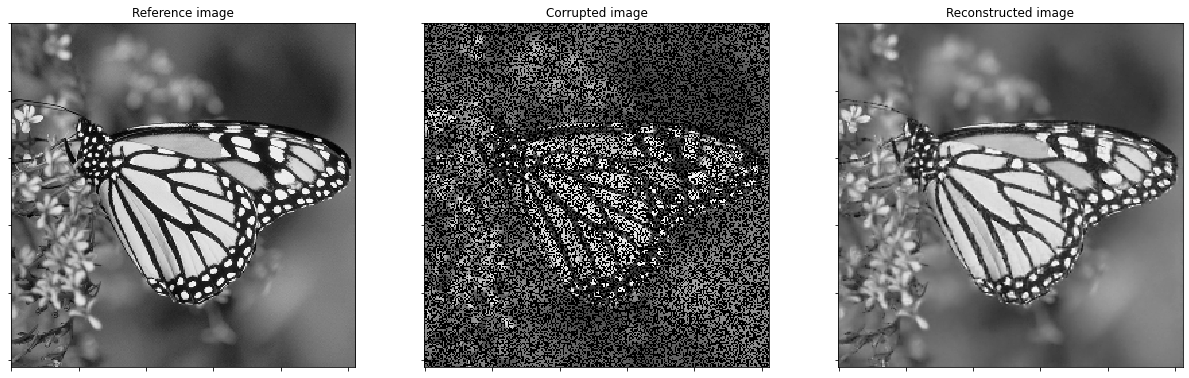

In [12]:
fig = plot.figure(figsize=(21, 7))
plot.subplot(1, 3, 1)
plot.imview(img, title='Reference image', fig=fig)
plot.subplot(1, 3, 2)
plot.imview(imgw, title='Corrupted image', fig=fig)
plot.subplot(1, 3, 3)
plot.imview(imgr, title='Reconstructed image', fig=fig)
fig.show()

Display lowpass component and sparse representation

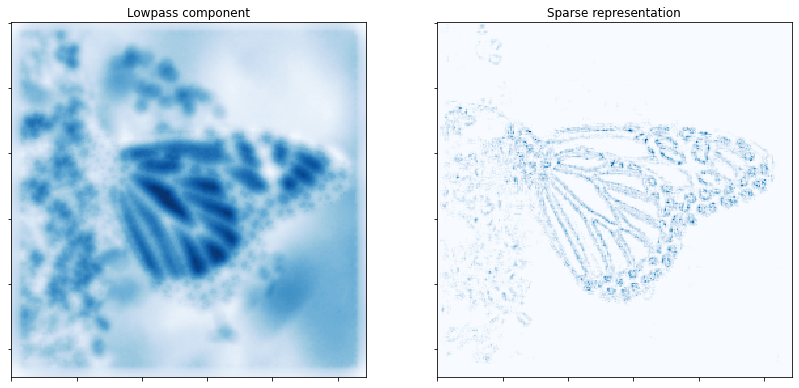

In [13]:
fig = plot.figure(figsize=(14, 7))
plot.subplot(1, 2, 1)
plot.imview(X[..., 0], cmap=plot.cm.Blues, title='Lowpass component', fig=fig)
plot.subplot(1, 2, 2)
plot.imview(np.sum(abs(X[..., 1:]).squeeze(), axis=-1), cmap=plot.cm.Blues,
            title='Sparse representation', fig=fig)
fig.show()

Plot functional value, residuals, and rho (not available if GPU implementation used).

In [14]:
if ams is not None:
    its = ams.getitstat()
    fig = plot.figure(figsize=(21, 7))
    plot.subplot(1, 3, 1)
    plot.plot(its.ObjFun, xlbl='Iterations', ylbl='Functional', fig=fig)
    plot.subplot(1, 3, 2)
    plot.plot(np.vstack((its.PrimalRsdl, its.DualRsdl)).T, ptyp='semilogy',
              xlbl='Iterations', ylbl='Residual', lgnd=['Primal', 'Dual'],
              fig=fig)
    plot.subplot(1, 3, 3)
    plot.plot(its.Rho, xlbl='Iterations', ylbl='Penalty Parameter', fig=fig)
    fig.show()